In [40]:
import IPython
IPython.get_ipython().kernel.do_one_iteration()
IPython.get_ipython().kernel.do_one_iteration()
IPython.get_ipython().kernel.do_one_iteration()

/tmp/ipykernel_34/3240601370.py:2: RuntimeWarning: coroutine 'Kernel.do_one_iteration' was never awaited
  IPython.get_ipython().kernel.do_one_iteration()
/tmp/ipykernel_34/3240601370.py:3: RuntimeWarning: coroutine 'Kernel.do_one_iteration' was never awaited
  IPython.get_ipython().kernel.do_one_iteration()


<coroutine object Kernel.do_one_iteration at 0x7961a8b4e7a0>

In [41]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import os
import numpy as np

def images_to_arrays(directory):
    image_arrays = []
    for filename in os.listdir(directory):
        if filename.endswith('.jpg') or filename.endswith('.png'):
            img = load_img(os.path.join(directory, filename), target_size=(256, 256)) 
            img_array = img_to_array(img)
            img_array = img_array.astype(np.uint8)
            image_arrays.append(img_array)
    return image_arrays

# Define the directory containing your images
directory1 = '/kaggle/input/potato-dataset/potato_dataset/Early_Blight'
directory2 = '/kaggle/input/potato-dataset/potato_dataset/Late_Blight'
directory3 = '/kaggle/input/potato-dataset/potato_dataset/healthy__'

# Convert images into arrays
Early_blight = images_to_arrays(directory1)
Late_blight = images_to_arrays(directory2)
healthy = images_to_arrays(directory3)

In [42]:

early_blight=np.array(Early_blight)
late_blight=np.array(Late_blight)
healthy=np.array(healthy)

In [43]:

# Create labels for each array
labels_0 = np.zeros((early_blight.shape[0],), dtype=int) 
labels_1 = np.ones((late_blight.shape[0],), dtype=int)  
labels_2 = np.full((healthy.shape[0],), 2, dtype=int)   

# Concatenate arrays and labels
data = np.concatenate((early_blight,late_blight,healthy), axis=0)
labels = np.concatenate((labels_0, labels_1, labels_2), axis=0)

# Shuffle the data and labels in the same order
shuffle_indices = np.random.permutation(len(data))
images = data[shuffle_indices]
labels = labels[shuffle_indices]


In [44]:
print(images.shape)

(5896, 256, 256, 3)


In [45]:
del Early_blight
del Late_blight
del early_blight
del late_blight
del healthy

In [46]:
np.save('images.npy',images)
np.save('labels.npy',labels)

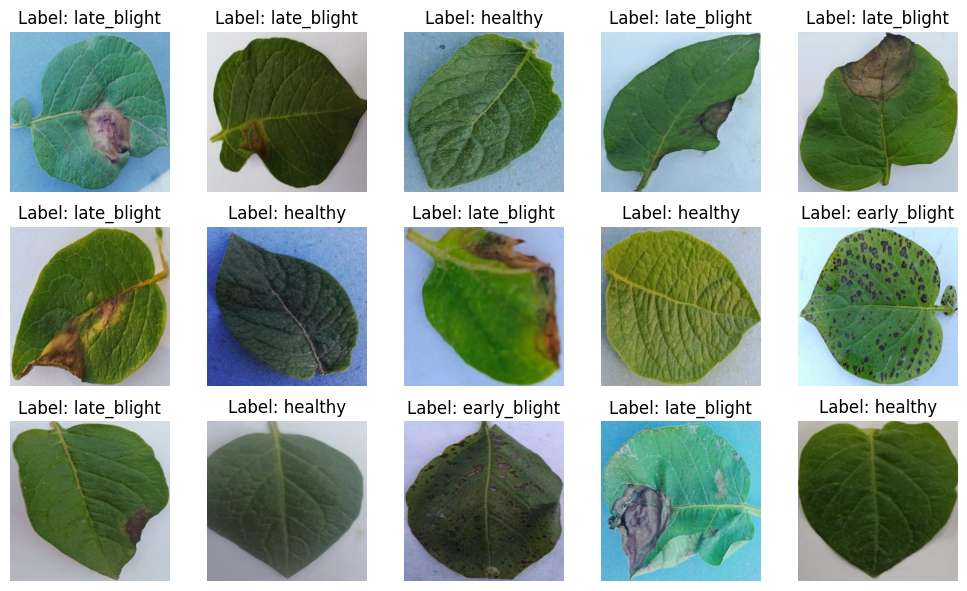

In [47]:
import matplotlib.pyplot as plt
import random

classes= ['early_blight','late_blight','healthy']

random.seed(43)
num_cols=5
num_rows=3

fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 6))
for i in range(num_cols*num_rows):
    x=random.randint(0,len(images)-1)
    img=images[x]
    label=labels[x]
    row = i // num_cols
    col = i % num_cols
    axes[row, col].imshow(img)
    axes[row, col].set_title(f"Label: {classes[label]}")
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

In [59]:
from sklearn.model_selection import train_test_split


x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=0.15, random_state=23)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=23)
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)
print(x_val.shape)
print(y_val.shape)

(4509, 256, 256, 3)
(4509,)
(885, 256, 256, 3)
(885,)
(502, 256, 256, 3)
(502,)


In [60]:
# Create TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))

# Optionally shuffle and batch the datasets
batch_size = 32
train_dataset = train_dataset.shuffle(buffer_size=len(x_train)).batch(batch_size)
test_dataset = test_dataset.batch(batch_size)
val_dataset = val_dataset.batch(batch_size)

In [50]:
del x_train 
del x_test
del x_val
del y_train
del y_test
del y_val

In [51]:
from tensorflow.keras import layers
data_augmentation = tf.keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(256,
                                  256,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

In [52]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

num_classes = 3

model = Sequential([
    layers.Rescaling(1./255, input_shape=(256, 256, 3)),
    data_augmentation,
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(128, 3, padding='same', activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.5),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [53]:
model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_3 (Rescaling)         │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_5 (Sequential)       │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 256, 256, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 128, 128, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 128, 128, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 512)            │    16,777,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,007,267 (64.88 MB)

 Trainable params: 17,007,267 (64.88 MB)

 Non-trainable params: 0 (0.00 B)

In [54]:
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [55]:
initial_learning_rate = 0.001

optimizer = Adam(learning_rate=initial_learning_rate)

history = model.fit(train_dataset, epochs=100,
                    validation_data=(val_dataset))

Epoch 1/100


2024-04-12 18:20:15.866514: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/sequential_6_1/dropout_9_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


141/141 ━━━━━━━━━━━━━━━━━━━━ 13s 69ms/step - accuracy: 0.4690 - loss: 1.0158 - val_accuracy: 0.7729 - val_loss: 0.6709
Epoch 2/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 9s 67ms/step - accuracy: 0.7141 - loss: 0.7000 - val_accuracy: 0.8068 - val_loss: 0.4794
Epoch 3/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 9s 67ms/step - accuracy: 0.7560 - loss: 0.6220 - val_accuracy: 0.7390 - val_loss: 0.5243
Epoch 4/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 9s 67ms/step - accuracy: 0.7952 - loss: 0.5281 - val_accuracy: 0.8486 - val_loss: 0.4059
Epoch 5/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 9s 67ms/step - accuracy: 0.8394 - loss: 0.4372 - val_accuracy: 0.8825 - val_loss: 0.3088
Epoch 6/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 9s 67ms/step - accuracy: 0.8589 - loss: 0.4060 - val_accuracy: 0.8207 - val_loss: 0.4530
Epoch 7/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 9s 66ms/step - accuracy: 0.8770 - loss: 0.3361 - val_accuracy: 0.9143 - val_loss: 0.2421
Epoch 8/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 9s 66ms/step - accuracy: 0.8819 - loss: 0.3137 - val_accurac

In [61]:
test_loss, test_acc = model.evaluate(test_dataset, verbose=2)
print(test_acc)

28/28 - 1s - 20ms/step - accuracy: 0.9932 - loss: 0.0250
0.993220329284668


In [67]:
model.save('/kaggle/working/model.h5')